## Load the Data 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls -ls /content/gdrive/'My Drive'/WJaguarTest

ls: cannot access '/content/gdrive/My Drive/WJaguarTest': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip   /content/gdrive/'My Drive'/WJaguarTest/news-category-dataset.zip

Archive:  /content/gdrive/My Drive/WJaguarTest/news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


#### Load libraries we will need 

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.linear_model import SGDClassifier
import logging
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
df_news = pd.read_json("/content/gdrive/My Drive/News_Category_Dataset_v2.json", lines = True)
df_news.columns

Index(['category', 'headline', 'authors', 'link', 'short_description', 'date'], dtype='object')

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [ ]:
df_news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


Category Distribution

In [ ]:
len(df_news['category'].unique())
print(df_news['category'].unique())

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']


There are 41 categories in the dataset

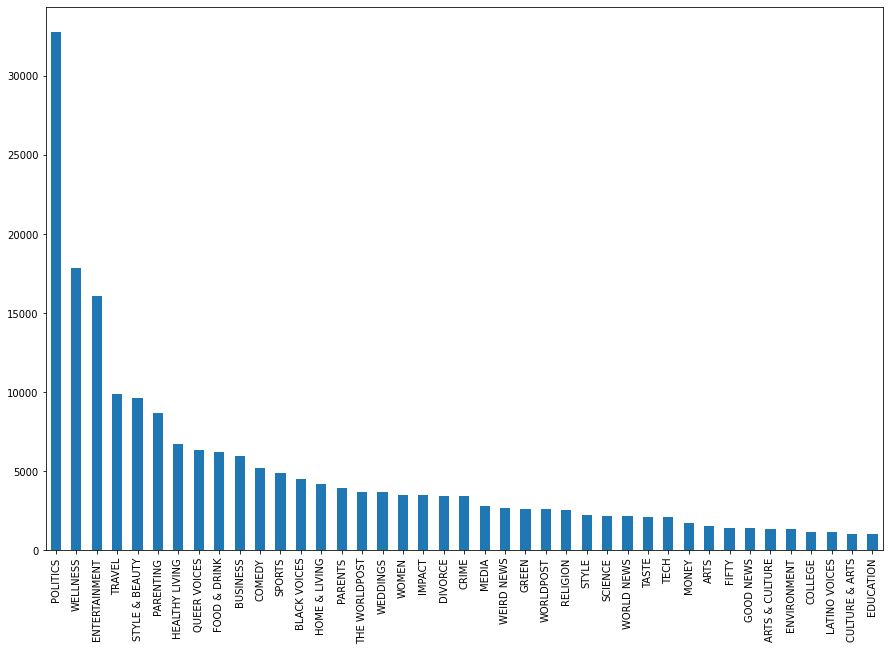

In [ ]:
df_news['category'].value_counts().plot( kind='bar', figsize=(15,10))

#### Data pre-processing

load the nltk utilities

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#### Function to clean, tokenize, remove stop word, and not alphanumeric from data

In [ ]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

my_sw = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']
def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text)    
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

In [ ]:
df_news.category[126] 

'TRAVEL'

#### Processing the Data and TF-IDF

We need to merge the categories _WORDLPOST_ with _THE WORDPOST_, because there *are* basically the same, next we combine the columns _headline with _short_description_ these are our predictor text

In [ ]:
df_news.category = df_news.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [ ]:
df_news['text'] = df_news['headline'] + " " + df_news['short_description']

example output

In [ ]:
print("headline: " + df_news.headline[10])
print("description: " + df_news.short_description[10])
print("text: " + df_news.text[10])

headline: Justin Timberlake Visits Texas School Shooting Victims
description: The pop star also wore a "Santa Fe Strong" shirt at his show in Houston.
text: Justin Timberlake Visits Texas School Shooting Victims The pop star also wore a "Santa Fe Strong" shirt at his show in Houston.


In [ ]:
clean_txt(df_news.text[10])

'justin timberlake visit texas school shoot victims pop star also wear santa strong shirt show houston'

In [ ]:
clean_txt(df_news.text[5])

'morgan freeman devastate sexual harassment claim could undermine legacy right equate horrific incidents sexual assault misplace compliment humor statement'

#### Next we are going to create some news variables columns to try to improve the quaity of our classifier, we will create:
 * Polarity: to check the sentiment of the text
 * Subjectivity: to check if text is objective or subjective
 * The number of word in the text

In [ ]:
#check whether spelling is correct
blob = TextBlob((df_news.text[11]))
str(blob.correct())

"South Organ President Meets North More's Him Long In To Talk Plump Summit The two met to have the way for a summit between North Organ and the U.S."

In [ ]:
print(df_news.text[11])

South Korean President Meets North Korea's Kim Jong Un To Talk Trump Summit The two met to pave the way for a summit between North Korean and the U.S.


In [ ]:
def polarity_txt(text):
  return TextBlob(text).sentiment[0] 

In [ ]:
def subj_txt(text):
  return  TextBlob(text).sentiment[1]

In [ ]:
#check the length of the preprocessed text
def len_text(text):
  if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
  else:
         return 0

In [ ]:
df_news['polarity'] = df_news['text'].apply(polarity_txt)
df_news.head(2)

,category,headline,authors,link,short_description,date,text,polarity
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,-0.05
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00


In [ ]:
df_news['subjectivity'] = df_news['text'].apply(subj_txt)
df_news.head(2)

,category,headline,authors,link,short_description,date,text,polarity,subjectivity
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,-0.05,0.266667
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00,0.000000


In [ ]:
#len_text to get the ratio of words after preprocessing. In English, you only need on average 35% of the words to make sense. In Chinese, you need more.
df_news['len'] = df_news['text'].apply(len_text)
df_news.head(2)

,category,headline,authors,link,short_description,date,text,polarity,subjectivity,len
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,-0.05,0.266667,0.444444
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00,0.000000,0.500000


#### Make the Custom class for feature union Transformer of sklearn

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer

#Create a data dictionary
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
#this class is going to take two functions:
    def fit(self, x, y=None):
        return self
#the object of this class is the key. we'll create a data dictionary that calls these functions.
    def transform(self, data_dict):
        return data_dict[self.key]

#We'll get these stats
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pos':  row['polarity'], 'sub': row['subjectivity'],  'len': row['len']} for _, row in data.iterrows()]


### Make our Custom Pipeline

In [ ]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text. We'll pull ngrams.
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features. We'll create a matrix with these stats.
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 'subjectivity', 'len'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion. Assign weights to the 2 groups of features you just pulled. You give more weight to sentiment.
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
])

##### Build the pipeline

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#to control results, use a seed
seed = 40
X = df_news[['text', 'polarity', 'subjectivity','len']]
y =df_news['category']
#one-hot encode category labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [ ]:
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [ ]:
#Grouped different features
pipeline.fit(x_train)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
                      

### Transform and train the ML models

In [ ]:
#check performance stats
%%time
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the number of features in train and test correspond: (160682, 189409) - (40171, 189409)
CPU times: user 1min 43s, sys: 46.7 ms, total: 1min 43s
Wall time: 1min 43s


In [ ]:
#We use these distance algorithms
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=10000) #Support Vector machines
clf_sgd = SGDClassifier(max_iter=200,) # Stochastic Gradient Classifier

In [ ]:
#check accuracy
%%time
from sklearn.model_selection import cross_val_score

clfs = [clf_sv, clf_sgd]
cv = 3
for clf in clfs:
    scores = cross_val_score(clf,train_vec, y_train, cv=cv, scoring="accuracy" )
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))

[0.60202386 0.60398424 0.60207244]
Mean score: 0.603 (+/-0.001)
[0.57582943 0.56789455 0.57554145]
Mean score: 0.573 (+/-0.004)
CPU times: user 2min 10s, sys: 13.2 s, total: 2min 24s
Wall time: 2min 8s


In [ ]:

%%time
from sklearn.metrics import classification_report
clf_sv.fit(train_vec, y_train)
y_pred = clf_sv.predict(test_vec)
print(classification_report(y_test, y_pred))
#list_result =[]
#list_result.append(("SVC",accuracy_score(y_test, y_pred)))
#clf_sgd.fit(train_vec, y_train )
#y_pred = clf_sgd.predict(test_vec)
#list_result.append(("SGD",accuracy_score(y_test, y_pred)))


              precision    recall  f1-score   support

           0       0.32      0.34      0.33       302
           1       0.30      0.32      0.31       268
           2       0.52      0.52      0.52       906
           3       0.50      0.49      0.49      1187
           4       0.41      0.56      0.48       229
           5       0.53      0.48      0.50      1035
           6       0.54      0.70      0.61       681
           7       0.41      0.36      0.38       206
           8       0.72      0.74      0.73       685
           9       0.37      0.48      0.41       201
          10       0.74      0.65      0.69      3212
          11       0.41      0.39      0.40       265
          12       0.25      0.29      0.27       280
          13       0.64      0.70      0.67      1245
          14       0.28      0.31      0.30       280
          15       0.37      0.47      0.41       524
          16       0.40      0.28      0.33      1339
          17       0.69    

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[102,  16,   5, ...,   6,   1,   6],
       [ 24,  85,   8, ...,  10,   1,   5],
       [  6,   8, 467, ...,  12,   3,   3],
       ...,
       [  4,   7,   5, ..., 270,   5,   0],
       [  1,   1,   2, ...,   5, 141, 129],
       [  7,   4,   8, ...,  12, 115, 764]])

### Deep Learning and Spacy Models

In [ ]:
import spacy
!python -m spacy download en_core_web_lg


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

OSError: ignored

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

In [ ]:
from sklearn.model_selection import train_test_split
import time
X = df_news['text']
y =df_news['category']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
Y = np_utils.to_categorical(y)
##Create the tf-idf vector
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = None, preprocessor=clean_txt)





In [ ]:
seed = 40
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify =y)
vectorizer.fit(x_train)

In [ ]:

word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()
 
def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_train]
print(X_train_sequences[0])
 

In [ ]:
# Compute the max lenght of a text

MAX_SEQ_LENGHT=60

N_FEATURES = len(vectorizer.get_feature_names())
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])
 

In [ ]:
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_test]
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
 

#### Making the spacy embeding

In [ ]:
EMBEDDINGS_LEN = 300

embeddings_index = np.zeros((len(vectorizer.get_feature_names()) + 1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
    try:
        embedding = nlp.vocab[word].vector
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)   
      

#### Simple LSTM Model

In [ ]:
 
model = Sequential()
model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(300, dropout=0.2))
model.add(Dense(len(set(y)), activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
model.fit(X_train_sequences, y_train, 
          epochs=5, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate(X_test_sequences, y_test, verbose=1)
print("Accuracy:", scores[1])  #
list_result.append(("LSTM Simple", scores[1]))

In [ ]:
len(x_train.keys())

### Model LSTM and concatenate new columns

In [ ]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((LSTM(300, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
df_cat_train = df_news.iloc[x_train.index][['polarity', 'subjectivity', 'len']]
df_cat_test = df_news.iloc[x_test.index][['polarity', 'subjectivity', 'len']]

In [ ]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=12, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  
list_result.append(("LSTM with Multi-Input", scores[1]))

### Model with 2 GRU (Bi-GRU)

In [ ]:

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((GRU(128, dropout=0.2, recurrent_dropout=0.2,  return_sequences=True)))(x)
x3 = ((GRU(128, dropout=0.2, recurrent_dropout=0.2)))(x2)
x4 = concatenate([x3, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=20, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  # 
list_result.append(("Bi-GRU", scores[1]))

## LSTM with Attention

In [ ]:
             
             
             
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x = Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False)(text_data)
x1 = (LSTM(300, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))(x)
x2 = Dropout(0.25)(x1)
x3 = Attention(MAX_SEQ_LENGHT)(x2)
x4 = Dense(256, activation='relu')(x3)
x5 = Dropout(0.25)(x4)
x6 = BatchNormalization()(x5)
x7 = concatenate([x6, meta_data])
x8 = Dense(150, activation='relu')(x7)
x9 = Dropout(0.25)(x8)
x10 = BatchNormalization()(x9)
outp = Dense(len(set(y)), activation='softmax')(x10)

AttentionLSTM = Model(inputs=[text_data, meta_data ], outputs=outp)
AttentionLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

AttentionLSTM.summary()

In [ ]:
AttentionLSTM.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=13, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = AttentionLSTM.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  # 
list_result.append(("LSTM with Attention", scores[1]))

##  Models Comparison

In [ ]:
pd.DataFrame(list_result, columns=['model', 'accuracy'])

The Confusion Matrix for the best models

## Do news articles from different categories have different writing styles?

#### Let's see the top word by category

In [ ]:
%%time
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(df_news.category)

In [ ]:

def create_tf_matrix(category):
    return vectorizer.transform(df_news[df_news.category == category].text)

def create_term_freq(matrix, cat):
  category_words = matrix.sum(axis=0)
  category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
  return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in df_news.category.unique():
  print("Top 10 terms for: ", cat)
  df_right = create_term_freq(create_tf_matrix(cat), cat).head(10)
  print(df_right)
  print("###############")
  if cat != 'CRIME':
    df_top5_words = df_top5_words.merge(df_right, how='outer')
  else:
    df_top5_words = df_right.copy()
  print(df_top5_words.shape )

  

In [ ]:
df_top5_words.fillna(0, inplace=True )
df_top5_words.set_index('Terms', inplace=True)
df_top5_words.shape

In [ ]:
!pip install textacy

In [ ]:
import numpy as np
from textacy.viz.termite import draw_termite_plot


In [ ]:
df = df_top5_words.copy()
df_norm = (df) / (df.max() - df.min())

#### According the TFIDF we get the following top-10  term by category

In [ ]:
draw_termite_plot(np.array(df_norm.values),df_top5_words.columns,df_top5_words.index, highlight_cols=[0, 4, 12,20,30,36] )

we see words for example: 
* for category _CRIME_ we have words like: _home,  crime,    black,  drink,  live, parent,   money_.
* for category _TRAVEL_ we have:  _world,  food, culture,     drink_ , i.e Wor we can use for travel description



Let´s get some metada data by categories

In [ ]:

import textacy

In [ ]:
def get_basic_stat(text):
  doc = textacy.make_spacy_doc(text, lang=nlp)
  ts = textacy.TextStats(doc)
  return  ts.basic_counts

Group by Categories in order to analize the Data

In [ ]:
%%time
df_news['Stats'] = df_news['text'].apply(get_basic_stat)

In [ ]:
df_news.head()

In [ ]:
df_stats = pd.DataFrame(df_news['Stats'].values.tolist(), index=df_news.index)
df_stats.head()

### The sentiment by Category

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
plt.figure(figsize=(20,11))
ax = sns.boxplot(x="category", y="polarity", data=df_news)
# ax = sns.swarmplot(x="category", y="polarity", data=df_news, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

The highest sentiment polarity score was achieved by all the categoris **TASTE  and FOOOD & DRING**, and the lowest sentiment polarity score was collected by categories **CRIME and WORLD NEWS**.  This is explains because categories as  _CRIME_ as some more words associated with negative feelings, whereas categories like **FOODS & DRINK** has more word associated to pleasure.

### The Objectivity by Category

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="category", y="subjectivity", data=df_news)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Objectivity by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

The highest subjectivity score by mean was achieved by categories **PARECTS, HOME & LIVING and TASTE** refers that mostly it is a public opinion and not a factual information., and the lowest subjectivity score was collected by **CRIME and WORLDPOST** for example.  however these text are all should considered to be objective because are all news.

### Articles Published by year

In [ ]:
df_news['year']= df_news['date'].dt.year

In [ ]:
ax.set_title('Number of news by Year')
ax = sns.countplot(x="year", data=df_news, palette="Blues_d")

The news published by year is kind of uniform

### News by category an year

In [ ]:
df_news['qty']= 1
df_cat_year = df_news.groupby(['category', 'year']).agg({'polarity': 'mean', 
                                     'subjectivity': 'mean', 
                                    'len': 'mean',
                                     'qty':'count'})
df_cat_year.head(6)

In [ ]:
df_cat_year.reset_index(inplace=True)

In [ ]:

fig1 = plt.figure(figsize=(15,25))
fig1.subplots_adjust(hspace = 1)
chrt = 0
for i, group in df_cat_year.groupby('category'):
    chrt += 1 
    ax = fig1.add_subplot(10,4, chrt)
    x = group['year']
    h = group['qty']
    ax.bar(x,h, color ="#86A3E2")
    ax.set_title(str(i))

**The polarity and subjectivity by category and year**

In [ ]:
fig1 = plt.figure(figsize=(15,25))
fig1.subplots_adjust(hspace = 1)
chrt = 0
for i, group in df_cat_year.groupby('category'):
    chrt += 1
    barWidth = 0.25
    ax = fig1.add_subplot(10,4, chrt)
    x = group.year
    bars1 = group.polarity
    bars2 = group.subjectivity
    r1 = np.arange(len(x))
    r2 = [x + barWidth for x in r1]

    ax.bar(r1, bars1, color='#F08080', width=barWidth, edgecolor='white', label='Polarity')
    ax.bar(r2, bars2, color='#B0C4DE', width=barWidth, edgecolor='white', label='Subjectivity')
    ax.set_title(str(i))
    ax.set_xticks(range(len(bars1)))
    ax.set_xticklabels([str(x1) for x1 in x], rotation=15)

### The stats by category 

the mean of number of words and unique  by category

In [ ]:
df_stats['category'] = df_news['category']
df_stats.head()

In [ ]:

plt.bar(x="category",height ='n_unique_words'  ,data=df_stats.groupby(['category']).mean().sort_values('n_unique_words', ascending=False).head(10).reset_index())
plt.title('Unique word by category')
plt.xticks(rotation=60)

In [ ]:
plt.bar(x="category",height ='n_sents'  ,data=df_stats.groupby(['category']).mean().sort_values('n_sents', ascending=False).head(10).reset_index())
plt.title('Numero de oraciones por categoría')
plt.xticks(rotation=60)

In [ ]:
plt.bar(x="category",height ='n_monosyllable_words'  ,data=df_stats.groupby(['category']).mean().sort_values('n_monosyllable_words', ascending=False).head(10).reset_index())
plt.title('Numero de monosílabas por categoría')
plt.xticks(rotation=60)

In [ ]:
plt.bar(x="category",height ='n_polysyllable_words'  ,data=df_stats.groupby(['category']).mean().sort_values('n_polysyllable_words', ascending=False).head(10).reset_index())
plt.title('Numero de Poly-sílabas por categoría')
plt.xticks(rotation=60)

In [ ]:
df_stats.groupby(['category']).mean().sort_values('n_unique_words', ascending=False).head(10).reset_index()

### What can be said about the authors?


In [ ]:
df_news['qty']= 1
df_authors = df_news.groupby(['authors']).agg({'polarity': 'mean', 
                                     'subjectivity': 'mean', 
                                    'len': 'mean',
                                     'qty':'count'}).reset_index()
df_authors.head()

In [ ]:
df_authors.drop([0], axis=0, inplace =True)

In [ ]:
df_authors.reset_index(drop=True, inplace=True)
df_authors.head()

####  Top Prolifics Authors

In [ ]:
df_authors.sort_values(['qty'], ascending=False).head(10)

In [ ]:
def plot_grouped_bar(df, title):
  barWidth = 0.25

  # set height of bar
  bars1 = df.polarity
  bars2 = df.subjectivity

  # Set position of bar on X axis
  r1 = np.arange(len(bars1))
  r2 = [x + barWidth for x in r1]

  # Make the plot
  plt.figure(figsize=(15,10))
  plt.bar(r1, bars1, color='#F08080', width=barWidth, edgecolor='white', label='Polarity')
  plt.bar(r2, bars2, color='#B0C4DE', width=barWidth, edgecolor='white', label='Subjectivity')

  # Add xticks on the middle of the group bars
  plt.title(title)
  plt.xlabel('group', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(bars1))], df.authors)
  plt.xticks(rotation=60)
  plt.legend()
  plt.show()

In [ ]:
plot_grouped_bar(df_authors.sort_values(['qty'], ascending=False).head(10), "Polarity and Subjectivity of the most Prolific Authors")

By means the author with the most articles  have written around 1000 articles along the years, with a hight subjectivity an neutral polarity.

In [ ]:
df_authors[df_authors.qty >100].sort_values(['polarity'], ascending=False).head(10)

In [ ]:

plot_grouped_bar(df_authors[df_authors.qty >100].sort_values(['polarity'], ascending=False).head(10), "Authors with top Polarities (more of 100 articles)")

In [ ]:
df_authors[df_authors.qty >100].sort_values(['subjectivity'], ascending=False).head(10)

In [ ]:
plot_grouped_bar(df_authors[df_authors.qty >100].sort_values(['subjectivity'], ascending=False).head(10), "Authors with top Subjectivities (more of 100 articles)")

### What useful information can be extracted from the data?